### Installing Libs

In [79]:
# Installing Libs

!pip3 install numpy matplotlib pandas tqdm ipykernel torchsummary scikit-learn
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

### Importing Libs

In [80]:
# Importing Libs

import torch
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm

### Utility Functions

In [81]:
device = "cpu"

def setup_device(to_print:bool=False):
    # Get cpu or gpu device for training.
    global device    
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if to_print:
        print("Using {} device".format(device))

### Loading Data

In [82]:
import os

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets

# def fetch_dataset(root:str='data', train_dataset:str='train', val_dataset:str=None, train_transform:transforms=None, val_transform:transforms=None, target_transform=None):
#     assert train_dataset in ['train', 'trainval'] and val_dataset in ['val', None]

#     if train_dataset == 'trainval':
#         train_data = ConcatDataset(
#             [
#                 ImageFolder(root=os.path.join(root,'train'), transform=train_transform, target_transform=target_transform),
#                 ImageFolder(root=os.path.join(root,'val'), transform=train_transform, target_transform=target_transform)
#             ]
#         )
#     else:
#         train_data = ImageFolder(root=os.path.join(root,train_dataset), transform=train_transform, target_transform=target_transform)

#     if val_dataset is None:
#         return train_data
    
#     val_data = ImageFolder(root=os.path.join(root,val_dataset), transform=val_transform, target_transform=target_transform)
#     return train_data, val_data

def fetch_dataset(dataset=datasets.CIFAR10, train_transform=None, test_transform=None, target_transform=None):
    """
    EXAMPLE: datasets.MNIST
    """
    kwargs = [
        dict(   
            train=True
        ),
        dict(
            train=False
        )
    ]
    if dataset == datasets.STL10:
        kwargs = [dict(split='train'), dict(split='test')]
    # download dataset
    train_data = dataset(
        root="data",
        **kwargs[0],
        download=True,
        transform=train_transform,
        target_transform=target_transform
    )

    test_data = dataset(
        root="data",
        **kwargs[1],
        download=True,
        transform=test_transform,
        target_transform=target_transform
    )
    return train_data, test_data

def get_dataloader(train_data, val_data=None, batch_size=256, train_sampler=None, shuffle=True, **kwargs):
    # create dataloaders
    test_sampler_kwargs = dict(shuffle=shuffle)
    sampler_kwargs = dict(sampler=train_sampler) if train_sampler else test_sampler_kwargs
    train_loader = DataLoader(train_data, batch_size=batch_size, **sampler_kwargs, **kwargs)
    if val_data is None:
        return train_loader
    val_loader = DataLoader(val_data, batch_size=batch_size, **test_sampler_kwargs)
    return train_loader, val_loader

#### Saving

In [83]:
def text_to_file(JOINED_PATH:str, contents, mode:str='w'):
    with open(JOINED_PATH, mode) as f:
        print(contents, file=f)

def save_model(model:nn.Module, PATH:str='models', FILENAME:str=None, extra_info:str=""):
    if FILENAME == None:
        import time
        FILENAME = f'model_{int(time.time())}.h5'

    import os
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    PATH = os.path.join(PATH, FILENAME)
    torch.save(model.state_dict(), PATH)

    text_to_file(PATH+'_details.txt', str(model)+'\n'+extra_info)
    return PATH

def load_model(model:nn.Module, FILE_PATH:str):
    if FILE_PATH is None:
        return
    model.load_state_dict(torch.load(FILE_PATH))

### Model

In [84]:
class Conv(nn.Module):
    def __init__(self, n_channels:int=3, n_classes:int=1000):
        super(Conv, self).__init__()
        self.n_channels = n_channels
        # self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(n_channels, 64, 7, 2, 2),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(256, 1024, 3, 2, 1),
            nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(1024, n_classes)

    def forward(self, x):
        # print(x.shape)
        x = self.conv(x)
        x = self.gap(x)
        x = self.flatten(x)
        # print(x.shape)
        logits = self.linear(x)
        return logits
    
    def __str__(self):
        return f'n_channels: {self.n_channels}\n\n'+super().__str__()
    

In [85]:
class _ResBlock(nn.Module):

    def __init__(self, inchannel, outchannel, stride=1):
        super(_ResBlock, self).__init__()

        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out
    
class _BigResBlock(nn.Module):

    def __init__(self, inchannel, midchannel, outchannel, stride=1):
        super(_BigResBlock, self).__init__()

        self.left = nn.Sequential(
            nn.BatchNorm2d(inchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inchannel,midchannel,kernel_size=1,stride=1,padding=0,bias=False),
            
            nn.BatchNorm2d(midchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(midchannel,midchannel,kernel_size=3,stride=stride,padding=1,bias=False),
            
            nn.BatchNorm2d(midchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(midchannel,outchannel,kernel_size=1,stride=1,padding=0,bias=False),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(inchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)

        return out
    
class ResNet18(nn.Module):

    def __init__(self, ResBlock=_ResBlock, num_classes=10, depth_multiple:int=2):
        super(ResNet18, self).__init__()

        assert depth_multiple >= 1

        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inchannel, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(self.inchannel),
            nn.ReLU()
        )
        self.lay1 = self.make_lay(ResBlock, 64 *depth_multiple, 2, stride=2)
        self.lay2 = self.make_lay(ResBlock, 128*depth_multiple, 2, stride=2)
        self.lay3 = self.make_lay(ResBlock, 256*depth_multiple, 2, stride=2)
        self.lay4 = self.make_lay(ResBlock, 512*depth_multiple, 2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512*depth_multiple, num_classes)
        
        
    def make_lay(self, block=_ResBlock, channels=64, num_blocks=2, stride=1):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.lay1(out)
        out = self.lay2(out)
        out = self.lay3(out)
        out = self.lay4(out)
        out = self.gap(out)
        out = self.flat(out)
        out = self.fc(out)

        return out
    
class ResNet34(nn.Module):

    def __init__(self, ResBlock=_ResBlock, in_channel=3, num_classes=10, first_lay_kernel_size=5, first_lay_stride=1, first_lay_padding=2):
        super(ResNet34, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, self.inchannel, kernel_size=first_lay_kernel_size, 
                      stride=first_lay_stride, padding=first_lay_padding, bias=False),
            nn.BatchNorm2d(self.inchannel),
            nn.ReLU()
        )
        self.lay1 = self.make_lay(ResBlock, 64, 3, stride=2)
        self.lay2 = self.make_lay(ResBlock, 128, 4, stride=2)
        self.lay3 = self.make_lay(ResBlock, 256, 6, stride=2)
        self.lay4 = self.make_lay(ResBlock, 512, 3, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)
        
        
    def make_lay(self, block=_ResBlock, channels=64, num_blocks=2, stride=1):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.lay1(out)
        out = self.lay2(out)
        out = self.lay3(out)
        out = self.lay4(out)
        out = self.gap(out)
        out = self.flat(out)
        out = self.fc(out)

        return out
    
    
class ResNet50(nn.Module):

    def __init__(self, ResBlock=_BigResBlock, num_classes=1000):
        super(ResNet50, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inchannel, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(self.inchannel),
            nn.ReLU()
        )
        self.lay1 = self.make_lay(ResBlock, 64, 3, stride=2)
        self.lay2 = self.make_lay(ResBlock, 128, 4, stride=2)
        self.lay3 = self.make_lay(ResBlock, 256, 23, stride=2)
        self.lay4 = self.make_lay(ResBlock, 512, 3, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(self.inchannel, num_classes)
        
        
    def make_lay(self, block=_BigResBlock, channels=64, num_blocks=2, stride=1):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, channels*4, stride))
            self.inchannel = channels*4
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.lay1(out)
        out = self.lay2(out)
        out = self.lay3(out)
        out = self.lay4(out)
        out = self.gap(out)
        out = self.flat(out)
        out = self.fc(out)

        return out

In [86]:
!git clone https://github.com/facebookresearch/deit deit

fatal: destination path 'deit' already exists and is not an empty directory.


In [87]:
from deit.models import deit_small_distilled_patch16_224


In [88]:
class DEIT(nn.Module):
    def __init__(self, num_classes):
        super(DEIT, self).__init__()
        self.deit = deit_small_distilled_patch16_224()
        self.fc = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.deit(x)
        if isinstance(x, tuple):
            x = x[0]
        x = self.fc(x)
        return x

In [89]:
!pip install transformers sentencepiece einops

In [90]:
import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = dim,
        ) 

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = "mean"
        self.to_latent = nn.Identity()

        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device

        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

In [91]:
#T2T-ViT
!git clone https://github.com/yitu-opensource/T2T-ViT t2t_vit

fatal: destination path 't2t_vit' already exists and is not an empty directory.


In [92]:
from t2t_vit.models.t2t_vit import t2t_vit_14

In [93]:
class T2T_ViT(nn.Module):
    def __init__(self, num_classes):
        super(T2T_ViT, self).__init__()
        self.t2t = t2t_vit_14(num_classes=num_classes)
        
    def forward(self, x):
        x = self.t2t(x)
        return x

### Training

In [94]:
def set_optimizers(model:nn.Module, loss_fn=nn.CrossEntropyLoss, optimizer=torch.optim.SGD, lr=1e-1, decay=None, **kwargs):
    # Loss function
    loss_fn = loss_fn()

    # SGD Optimizer
    optimizer = optimizer(model.parameters(), lr=lr)
    scheduler = decay(optimizer, **kwargs) if decay != None else None
    return loss_fn, optimizer, scheduler

# Train function
def train(dataloader:DataLoader, model:nn.Module, loss_fn, optimizer, scheduler=None, show:bool=True, tqdm_show:bool=False):
    size = len(dataloader.dataset)
    
    # Turn on training mode
    model.to(device)
    model.train()
    train_loss, correct = 0, 0
    dtlr = tqdm(dataloader) if tqdm_show else dataloader
    for X, y in dtlr:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        
        # print(X.shape, y.shape)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    
    train_loss /= len(dataloader)
    correct /= size
    lr = optimizer.param_groups[0]['lr']
    if scheduler != None:
        scheduler.step(train_loss) if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else scheduler.step()
    
    if show:
        print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}, lr: {lr}")
    return train_loss, correct, lr

# Test function
def test(dataloader:DataLoader, model:nn.Module, loss_fn, show:bool=True, tqdm_show:bool=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Turn on evalution mode
    model.eval()
    test_loss, correct = 0, 0
    
    # Turn off gradient descent
    with torch.no_grad():
        dtlr = tqdm(dataloader) if tqdm_show else dataloader
        for X, y in dtlr:
            X, y = X.to(device), y.to(device)
            # try:
            pred = model(X)
            # except Exception:
            #     print(X.shape, y.shape)
            
            # record loss
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    
    if show:
        print(f" Test accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, correct

In [95]:
def ToGPU(samp):
    return samp.to(device)

In [96]:
def GaussianNoise(samp):
    return samp + .02*torch.randn_like(samp, device=device) #.01

In [97]:
from torch.utils.data import SubsetRandomSampler

def get_sampler(fraction, dataset:datasets.CIFAR10):
    # balanced sampling
    indexes = [[] for _ in range(len(dataset.classes))]
    for idx, (_, class_idx) in enumerate(dataset):
        indexes[np.argmax(class_idx)].append(idx)
    train_indices = []
    for cl_idx in indexes:
        size = len(cl_idx)
        split = int(np.floor(fraction * size))
        np.random.shuffle(cl_idx)
        train_indices.extend(cl_idx[:split])
    return SubsetRandomSampler(train_indices)

### Main Function

In [98]:
from torchvision import datasets
BATCH_SIZE = 32
N_CLASSES = 10#100
IMG_SIZE = (224,224)#(64,64)
# IMG_SIZE = (64,64)
PATCH_SIZE = (16,16)

In [99]:
torch.cuda.empty_cache()

In [100]:
debug = False

setup_device(to_print=True)

configs = dict(interpolation=transforms.InterpolationMode.NEAREST)
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ToGPU,
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=35, **configs),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(.6,1), antialias=True, **configs),
        transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5), # 4
        transforms.RandomPerspective(distortion_scale=0.4, **configs), ## 201+
        GaussianNoise, ## NEW
    ]
)
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ToGPU,
        transforms.Resize(IMG_SIZE, **configs)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ToGPU,
        transforms.Resize(IMG_SIZE, **configs)
    ]
)
target_transform = lambda label: F.one_hot(torch.LongTensor(np.array([label])),num_classes=N_CLASSES).flatten().float()

dataset = datasets.CIFAR10
fraction = 1
# dataset = datasets.STL10
np.random.seed(42)
train_data, val_data = fetch_dataset(dataset, train_transform=train_transform, test_transform=val_transform, target_transform=target_transform)
sampler = get_sampler(fraction, train_data)
# train_data, val_data = fetch_dataset(
#     root='data',
#     train_dataset='train', val_dataset='val', 
#     train_transform=train_transform, 
#     val_transform=transforms.ToTensor(),
#     target_transform=target_transform
# )

Using cuda device
Files already downloaded and verified
Files already downloaded and verified


classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train size: 50000, val size: 10000
input size: torch.Size([32, 3, 224, 224]), label size: torch.Size([32, 10])


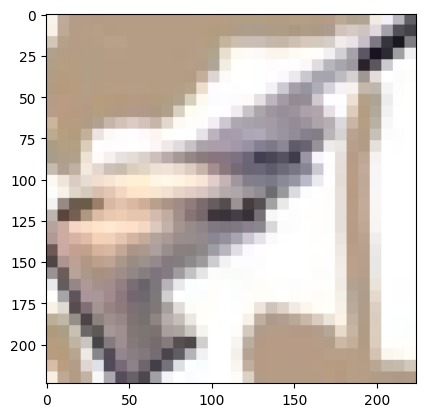

label: 0
input size: torch.Size([32, 3, 224, 224]), label size: torch.Size([32, 10])


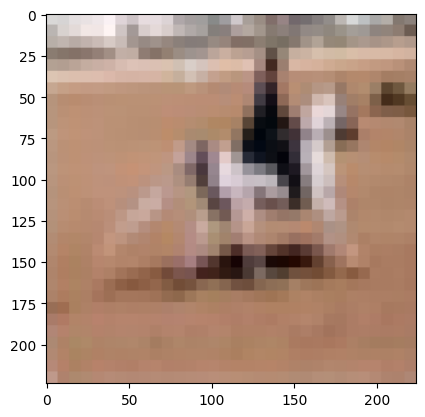

label: 7


In [101]:
train_loader, val_loader = get_dataloader(train_data, val_data, batch_size=BATCH_SIZE, shuffle=True, train_sampler=sampler) #1,2,4
#train_loader, val_loader = get_dataloader(train_data, val_data, batch_size=128, shuffle=True) #1,2,4
#train_loader, val_loader = get_dataloader(train_data, val_data, batch_size=64) #3

debug = True
if debug:
    print(f'classes: {train_data.classes}')
    print(f'train size: {len(train_loader.dataset)}, val size: {len(val_loader.dataset)}')

    data = next(iter(train_loader))
    print(f'input size: {data[0].shape}, label size: {data[1].shape}')
    plt.imshow(np.transpose(data[0][0].cpu(), (1,2,0)))
    plt.show()
    print(f'label: {torch.argmax(data[1][0])}')

    data = next(iter(val_loader))
    print(f'input size: {data[0].shape}, label size: {data[1].shape}')
    plt.imshow(np.transpose(data[0][0].cpu(), (1,2,0)))
    plt.show()
    print(f'label: {torch.argmax(data[1][0])}')

In [102]:
SUBLABEL = f'no_aug_split_{fraction}'

In [103]:
from torchsummary import summary

#model = Conv(n_channels=3, n_classes=1000) #1
#model = ResNet18(num_classes=10, depth_multiple=2) #2, 4
# model = ResNet34(num_classes=N_CLASSES) #3
#model = ResNet50(num_classes=10) # Kaggle
#model = ResNet18pFC(num_classes=1000)
# model = SimpleViT(image_size=IMG_SIZE, patch_size=PATCH_SIZE, num_classes=N_CLASSES, dim=500, depth=16, heads=8, mlp_dim=500, channels = 3, dim_head = 64)
# model = DEIT(num_classes=N_CLASSES)
model = T2T_ViT(num_classes=N_CLASSES)
model = model.to(device) 
SUB_DIR = os.path.join('classification',f'{dataset.__name__}_{model.__class__.__name__}_{SUBLABEL}')

if debug:
    summary(model, next(iter(train_loader))[0].shape[1:])

    data = next(iter(train_loader))
    print(f'input size: {data[0].shape}, label size: {data[1].shape}')
    outp = model(data[0].to(device))
    print(f'label: {torch.argmax(data[1][0])}, pred: {torch.argmax(outp[0])}')

adopt performer encoder for tokens-to-token
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1            [-1, 147, 3136]               0
         LayerNorm-2            [-1, 3136, 147]             294
            Linear-3            [-1, 3136, 192]          28,416
            Linear-4             [-1, 3136, 64]           4,160
           Dropout-5             [-1, 3136, 64]               0
         LayerNorm-6             [-1, 3136, 64]             128
            Linear-7             [-1, 3136, 64]           4,160
              GELU-8             [-1, 3136, 64]               0
            Linear-9             [-1, 3136, 64]           4,160
          Dropout-10             [-1, 3136, 64]               0
  Token_performer-11             [-1, 3136, 64]               0
           Unfold-12             [-1, 576, 784]               0
        LayerNorm-13             [-1, 784, 576]           1

In [104]:
#INITIAL_LR = 1e-3 #First training
INITIAL_LR = 8e-5 #ViT
#INITIAL_LR = 8e-05 #Start from saved point
#INITIAL_LR = 1e-4
#INITIAL_LR = 1e-5

In [105]:
#LOAD_PATH = '/models/resnet_50/1/model_1708420238.h5'
#LOAD_PATH = os.path.join('models','resnet_50','4','model_1708447042.h5')
#LOAD_PATH = os.path.join('models','resnet_18_good','model_1706970580.h5')
#LOAD_PATH = os.path.join('models','SimpleViT_1708653384','60','model_1708670107.h5')
LOAD_PATH = None
load_model(model, LOAD_PATH)

In [106]:
#GAMMA = .95
#GAMMA = .9
GAMMA = .999

In [107]:
# DECAY = torch.optim.lr_scheduler.ExponentialLR
# kwargs =  dict(gamma=GAMMA)
DECAY = torch.optim.lr_scheduler.ReduceLROnPlateau
kwargs =  dict(threshold_mode='rel')

In [108]:
#loss_fn, opt, scheduler = set_optimizers(model, nn.CrossEntropyLoss, torch.optim.Adam, lr=5e-3, decay=torch.optim.lr_scheduler.ExponentialLR, gamma=.97) #1
#loss_fn, opt, scheduler = set_optimizers(model, nn.CrossEntropyLoss, torch.optim.Adam, lr=1e-2, decay=torch.optim.lr_scheduler.ExponentialLR, gamma=.97) # 2,3,4
loss_fn, opt, scheduler = set_optimizers(model, nn.CrossEntropyLoss, torch.optim.Adam, lr=INITIAL_LR, decay=DECAY, **kwargs) # 4.1

In [109]:
import time
TRAIN_ID = int(time.time())

In [110]:
epoch = 0 # starting epoch
#epoch = 100
#epoch = 70

## Some Other Utility Functioins

In [111]:
training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []
lrs = []

In [112]:
def train_(epochs:int=100, show:bool=True, show2:bool=False):
    global epoch, training_losses, validation_losses, training_accuracy, validation_accuracy, lrs
    rng = range(epochs)
    rng = tqdm(rng) if show2 else rng
    for t in rng:
        if show:
            print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)
        shw = show or t == epochs-1
        loss, train_accuracy, lr = train(train_loader, model, loss_fn, opt, scheduler=scheduler, show=shw, tqdm_show=show)
        val_loss, val_accuracy = test(val_loader, model, loss_fn, show=shw, tqdm_show=show)
        training_losses.append(loss)
        validation_losses.append(val_loss)
        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)
        lrs.append(lr)
        epoch += 1

In [113]:
def plot(PTH):
    plt.plot(training_accuracy, label=f'Train Accuracy\nBest: {max(training_accuracy)}')
    plt.plot(validation_accuracy, label=f'Test Accuracy\nBest: {max(validation_accuracy)}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_accs.png')
    plt.show()

    plt.plot(np.log10(lrs), label=f'Lrs\nFinal: {lrs[-1]}')
    plt.ylabel('log lr (base 10)')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_lrs.png')
    plt.show()

In [114]:
def save(TRAIN_ID):
    extra_info = f" Train accuracy: {(100*training_accuracy[-1]):>0.1f}%, Avg loss: {training_losses[-1]:>8f}, lr: {lrs[-1]}"
    if validation_accuracy is not None:
        extra_info += f"\n Test accuracy: {(100*validation_accuracy[-1]):>0.1f}%"
        if validation_losses is not None: 
            extra_info += f", Avg loss: {validation_losses[-1]:>8f}"
    return save_model(model=model, PATH=os.path.join('models',SUB_DIR, f'{str(model.__class__.__qualname__)}_{str(TRAIN_ID)}'), extra_info=extra_info)

## The Training

In [115]:
NUM_EPOCHS = 2000
NUM_EPOCHS_TO_SAVE = 10#50
SHOW = False
SHOW2 = True

In [116]:
print(device)

cuda


EPOCH 0


 90%|█████████ | 9/10 [59:45<06:38, 398.50s/it]

 Train accuracy: 90.9%, Avg loss: 0.262019, lr: 8e-05


100%|██████████| 10/10 [1:06:23<00:00, 398.37s/it]

 Test accuracy: 72.8%, Avg loss: 0.912609


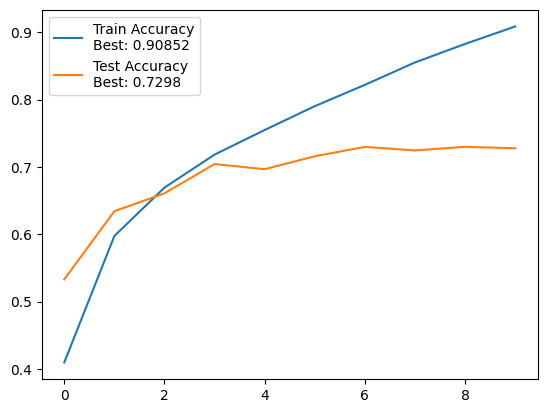

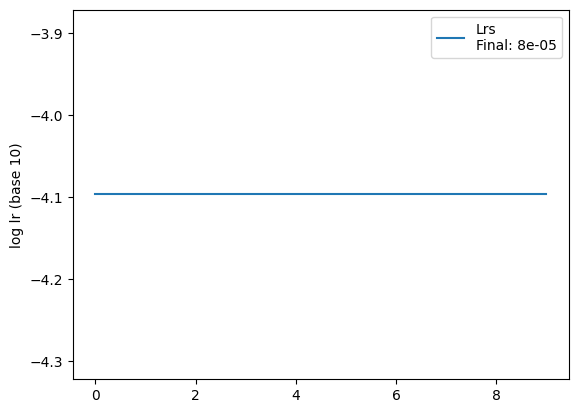

EPOCH 10


 30%|███       | 3/10 [19:55<46:29, 398.51s/it]

In [ ]:
for i in range(NUM_EPOCHS//NUM_EPOCHS_TO_SAVE):
    print('EPOCH', epoch)
    train_(epochs=NUM_EPOCHS_TO_SAVE, show=SHOW, show2=SHOW2)
    STORE_PATH = save(os.path.join(str(TRAIN_ID), f'{epoch}'))
    plot(STORE_PATH)